# This notebook includes the following algorithms:
* Naive Bayes classifiers
* Nonlinear SVM
* Bagging w/ random forests
* Boosting w/ stochastic gradient boosting
* Generic ensemble approach
* Neural networks

* Use the data to predict in league 2019 or not.
* Use the decision tree classifier, grid search, and the attributes to control model complexity to find the best version of this model (i.e., highest average accuracy in test data).
* Do the same task, but use random forests instead. Compare the results.
* Repeat with gradient boosting classifier.
* What are your takeaways?

In [169]:
# data packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

# algorithms
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

# organizing tests
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# some metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#plots
from sklearn.tree import plot_tree

In [170]:
df = pd.read_csv('predicting_inleague.csv')
df.head()

,playerID,inleague_2019,G_2016,G_2017,G_2018,AB_2016,AB_2017,AB_2018,R_2016,R_2017,...,HBP_2018,SH_2016,SH_2017,SH_2018,SF_2016,SF_2017,SF_2018,GIDP_2016,GIDP_2017,GIDP_2018
0,abadfe01,1.0,39.0,48.0,NaN,1.0,0.0,NaN,0.0,0.0,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
1,abreujo02,1.0,159.0,156.0,128.0,624.0,621.0,499.0,67.0,95.0,...,11.0,0.0,0.0,0.0,9.0,4.0,6.0,21.0,21.0,14.0
2,acunaro01,1.0,NaN,NaN,111.0,NaN,NaN,433.0,NaN,NaN,...,6.0,NaN,NaN,0.0,NaN,NaN,3.0,NaN,NaN,4.0
3,adamecr01,1.0,121.0,12.0,NaN,225.0,13.0,NaN,25.0,1.0,...,NaN,3.0,0.0,NaN,0.0,0.0,NaN,5.0,0.0,NaN
4,adamewi01,1.0,NaN,NaN,85.0,NaN,NaN,288.0,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,6.0


In [171]:
df.inleague_2019.describe()

count    1957.000000
mean        0.582013
std         0.493354
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: inleague_2019, dtype: float64

In [172]:
df.inleague_2019.value_counts()

1.0    1139
0.0     818
Name: inleague_2019, dtype: int64

In [173]:
# Fix missing records
df.fillna(0, inplace=True)

## Decision Tree Modeling

In [190]:
# split out your target feature and your other features that you will use to predict the target
xcols = df.columns[2 : len(df.columns)].to_list()
X, y = df[xcols], df[['inleague_2019']]
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (1957, 51) 
y shape: (1957, 1)


In [175]:
#fit the decision tree and output accuracy constrained by depth
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X, y)
print('Accuracy of Decision Tree classifier: {:.2f}'
     .format(clf.score(X, y)))

Accuracy of Decision Tree classifier: 0.84


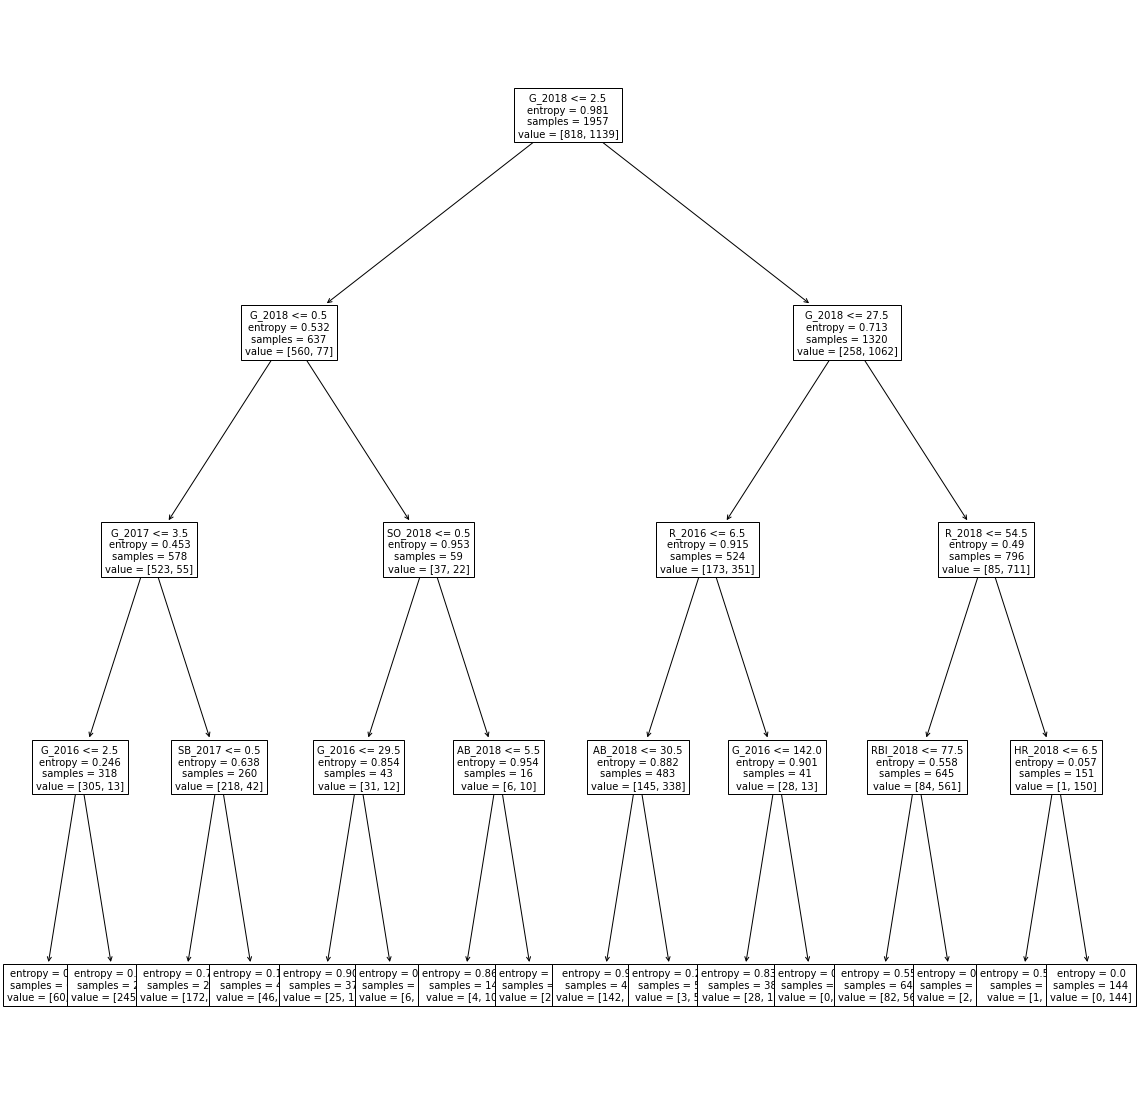

In [176]:
# plotting the tree

f = plt.figure(figsize=[20, 20])
plot_tree(clf, feature_names=xcols, fontsize=10)
f.savefig("decision_tree.pdf", bbox_inches='tight')

In [178]:
# summarize feature importance, and store values under feature names in scores dictionary
importance = clf.feature_importances_
scores = {}
for i,v in enumerate(importance):
    #print('Feature: %s, Score: %.5f' % (xcols[i],v))
    scores[xcols[i]] = v

#reverse sort 'scores' dictionary by values
import operator
sorted_scores = sorted(scores.items(), key=operator.itemgetter(1),reverse=True)

#print top 10 features
for feature, score in sorted_scores[0:25]:
    print(feature, ':', score)

G_2018 : 0.8660854948999953
R_2018 : 0.025495100757142234
AB_2018 : 0.02527753981410228
G_2017 : 0.021200753216647012
R_2016 : 0.0198716004915172
G_2016 : 0.01476655934715207
SB_2017 : 0.009925821906395304
RBI_2018 : 0.0070054350835300535
HR_2018 : 0.0053734459434252105
SO_2018 : 0.004998248540093274
AB_2016 : 0.0
AB_2017 : 0.0
R_2017 : 0.0
H_2016 : 0.0
H_2017 : 0.0
H_2018 : 0.0
2B_2016 : 0.0
2B_2017 : 0.0
2B_2018 : 0.0
3B_2016 : 0.0
3B_2017 : 0.0
3B_2018 : 0.0
HR_2016 : 0.0
HR_2017 : 0.0
RBI_2016 : 0.0


<ipython-input-40-f0176acb5b8d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = top_feats, rotation=45)


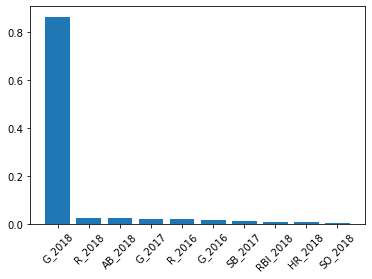

In [40]:
# first extract the top ten features into two lists that can be passed to plotting function
top_feats, top_vals = [], []
for feat_name, value in sorted_scores[0 : 10]:
    top_feats.append(feat_name)
    top_vals.append(value)

# plot feature importance for top 10 features
# plotting function
fig, ax = plt.subplots(1, 1)
feats_plot = ax.bar(top_feats, top_vals)
ax.set_xticklabels(labels = top_feats, rotation=45)
plt.show()

In [41]:
# train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[xcols], df[['inleague_2019']], 
                                                    random_state=0)
print(X_train.shape)
print(X_test.shape,'\n')

clf = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

print('Accuracy of classifier on training set: {:.2f}'
         .format(clf.score(X_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'
         .format(clf.score(X_test, y_test)))

(1467, 51)
(490, 51) 

Accuracy of classifier on training set: 0.99
Accuracy of classifier on test set: 0.75


In [81]:
# limit tree complexity
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(X_train, y_train)

print('Accuracy of classifier on training set: {:.2f}'
         .format(clf.score(X_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'
         .format(clf.score(X_test, y_test)))

#f = plt.figure(figsize=[10, 10])
#plot_tree(clf, feature_names=xcols, fontsize=10)
#print('\nyou can see the constrained tree depth')

Accuracy of classifier on training set: 0.84
Accuracy of classifier on test set: 0.83


In [142]:
# let's work w/ a simpler set of features to look at prediction

xcols2 = ['G_2018', 'R_2018', 'AB_2018', 'G_2017']
X2 = df[xcols2]
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(X2, y)
print('Accuracy of Decision Tree classifier: {:.2f}'
     .format(clf.score(X2, y)))


#output the decision trees w/ proportions

#f = plt.figure(figsize=[10, 10])
#plot_tree(clf, feature_names=xcols2, fontsize=10, proportion=True)
#f.savefig("decision_tree_2features.pdf", bbox_inches='tight')

Accuracy of Decision Tree classifier: 0.83


In [143]:
# train-test split
#from sklearn.model_selection import train_test_split

X2_train, X2_test, y_train, y_test = train_test_split(df[xcols2], df[['inleague_2019']], 
                                                    random_state=0)
print(X_train.shape)
print(X_test.shape,'\n')

clf = DecisionTreeClassifier(criterion='entropy',max_depth=3).fit(X_train, y_train)

print('Accuracy of classifier on training set: {:.2f}'
         .format(clf.score(X_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'
         .format(clf.score(X_test, y_test)))

(1467, 4)
(490, 4) 

Accuracy of classifier on training set: 0.84
Accuracy of classifier on test set: 0.83


In [125]:
# scale data first (note: should put this in a pipeline to avoid data leakage)
scaler = MinMaxScaler()
scaled_X2 = scaler.fit_transform(X2)

scaledx2_train = scaler.fit_transform(X2_train)
scaledx2_test = scaler.fit_transform(X2_test)

In [144]:
scaledx2_train, scaledx2_test, y_train, y_test = train_test_split(df[xcols2], df[['inleague_2019']], 
                                                    random_state=0)


print(X2_train.shape)
print(X2_test.shape,'\n')

clf = DecisionTreeClassifier(criterion='entropy',max_depth=3).fit(scaledx2_train, y_train)

print('Accuracy of classifier on scaled training set: {:.2f}'
         .format(clf.score(scaledx2_train, y_train)))
print('Accuracy of classifier on scaled test set: {:.2f}'
         .format(clf.score(scaledx2_test, y_test)))

(1467, 4)
(490, 4) 

Accuracy of classifier on scaled training set: 0.84
Accuracy of classifier on scaled test set: 0.83


## Grid Search (Tree Model)

In [145]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [152]:
std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('dec_tree', dec_tree)])

In [153]:
n_features = list(range(1,X.shape[1]+1,1))

In [148]:
criterion = ['gini','entropy']
max_depth = [2,4,6,8,10,12]

In [154]:
parameters = dict(pca__n_components=n_features,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)

In [134]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, y)

print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Features:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])


Best Criterion: entropy
Best max_depth: 6
Best Number Of Components: 25

DecisionTreeClassifier(criterion='entropy', max_depth=6)


In [184]:
#X3 = df[xcols[0:25]]
#print(xcols[0:25])

X3 = ['G_2018','R_2018','AB_2018','G_2017','R_2016', 'G_2016','SB_2017','RBI_2018','HR_2018','SO_2018','AB_2016','AB_2017','R_2017','H_2016','H_2017','H_2018','2B_2016','2B_2017','2B_2018','3B_2016','3B_2017','3B_2018','HR_2016','HR_2017','RBI_2016'] 
print(X3)


['G_2018', 'R_2018', 'AB_2018', 'G_2017', 'R_2016', 'G_2016', 'SB_2017', 'RBI_2018', 'HR_2018', 'SO_2018', 'AB_2016', 'AB_2017', 'R_2017', 'H_2016', 'H_2017', 'H_2018', '2B_2016', '2B_2017', '2B_2018', '3B_2016', '3B_2017', '3B_2018', 'HR_2016', 'HR_2017', 'RBI_2016']


In [185]:
scaled_X3 = scaler.fit_transform(df[X3])
scaledx3_train, scaledx3_test, y_train, y_test = train_test_split(df[X3], df[['inleague_2019']], 
                                                    random_state=0)


print(scaledx3_train.shape)
print(scaledx3_test.shape,'\n')

clf = DecisionTreeClassifier(criterion='entropy',max_depth=6).fit(scaledx3_train, y_train)

print('Accuracy of classifier on scaled training set: {:.2f}'
         .format(clf.score(scaledx3_train, y_train)))
print('Accuracy of classifier on scaled test set: {:.2f}'
         .format(clf.score(scaledx3_test, y_test)))

(1467, 25)
(490, 25) 

Accuracy of classifier on scaled training set: 0.86
Accuracy of classifier on scaled test set: 0.82


* After scaling the data and doing grid search for best parameters, I found that grid suggested the model to use 25 features and max depth of 6,the accuracy of train data slightly improved to 0.86, but acurracy using test data remained same 0.82.
* The model which uses 4 features and max depth of 3 can give the same text accuracy is 0.83, with trained data accuracy of 0.84. 

In [195]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# train Gaussian Naive Bayes model
gnb = GaussianNB().fit(X_train, y_train)

# output stats
print('Accuracy of Gaussian Naive Bayes classifier on training set: {:.2f}'
         .format(gnb.score(X_train, y_train)))
print('Accuracy of Gaussian Naive Bayes classifier on test set: {:.2f}'
         .format(gnb.score(X_test, y_test)))

Accuracy of Gaussian Naive Bayes classifier on training set: 0.60
Accuracy of Gaussian Naive Bayes classifier on test set: 0.59


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Bagging w/ Random forests

In [191]:
start = time.time()

# scale data first (note: should put this in a pipeline to avoid data leakage)
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# set-up grid of parameters to search
param_grid = {'n_estimators': [10, 100, 250], 'max_samples': [.25, .5, 1]} 
# n_estimators controls how many models to aggregate (i.e., how many trees in the forest)
#  each model will work with a random sample of features
#  and also with the max_samples parameter, a random sample of observations 
# max_samples controls what % of the observations each tree will use
# note: could also set max_features to control # of different features to sample
#  default: max_features=sqrt(n_features)

# instantiate grid search object
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3)

# fitting the model for grid search 
grid.fit(scaled_X, y)

#max_features=sqrt(n_features)

# print parameters, mean, and standard deviation of scores by iteration
for z in range(0, len(grid.cv_results_['params'])):
    print('\nparams:', grid.cv_results_['params'][z])
    print('mean of accuracies:', grid.cv_results_['mean_test_score'][z])
    print('std dev of accuracies:', grid.cv_results_['std_test_score'][z])
#    print('maximum features',max_features)

# print best parameter after tuning 
print('\n***best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

# store the best estimator
best_rf = grid.best_estimator_

mins = (time.time() - start) / 60
print('\ncomputation took', mins, 'minutes')

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataCon


params: {'max_samples': 0.25, 'n_estimators': 10}
mean of accuracies: 0.812470836190995
std dev of accuracies: 0.003887815489782332

params: {'max_samples': 0.25, 'n_estimators': 100}
mean of accuracies: 0.8329113388889411
std dev of accuracies: 0.007733597168907484

params: {'max_samples': 0.25, 'n_estimators': 250}
mean of accuracies: 0.8349539799008509
std dev of accuracies: 0.004297462684870786

params: {'max_samples': 0.5, 'n_estimators': 10}
mean of accuracies: 0.8160456536920991
std dev of accuracies: 0.008195232408881863

params: {'max_samples': 0.5, 'n_estimators': 100}
mean of accuracies: 0.8288221422598859
std dev of accuracies: 0.004293864513293139

params: {'max_samples': 0.5, 'n_estimators': 250}
mean of accuracies: 0.8272899657706918
std dev of accuracies: 0.004612735741238098

params: {'max_samples': 1, 'n_estimators': 10}
mean of accuracies: 0.582013328447906
std dev of accuracies: 0.0006289434341565789

params: {'max_samples': 1, 'n_estimators': 100}
mean of accuraci

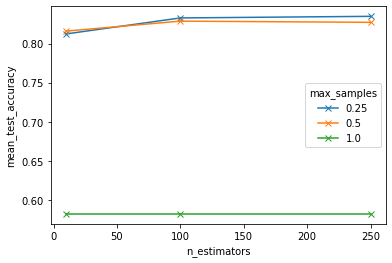

In [192]:
# graphing the results

# compile parameter and results into a dataframe
tmp = pd.DataFrame(grid.cv_results_['params'])
tmp2 = pd.DataFrame(grid.cv_results_['mean_test_score'], columns=['mean_test_score'])
tmp = pd.concat([tmp, tmp2], axis=1)
tmp.head()

# send to a graph
fig, ax = plt.subplots(figsize=(6,4))
for label, dfs in tmp.groupby('max_samples'):
    plt.plot(dfs.n_estimators, dfs.mean_test_score, marker='x', label=label)
plt.xlabel('n_estimators')
plt.ylabel('mean_test_accuracy')
plt.legend(title='max_samples')

## Boosting w/ stochastic gradient boosting

In [193]:
start = time.time()

# set-up grid of parameters to search
param_grid = {'n_estimators': [10, 100, 250], 'learning_rate': [.01, .1, .25],
              'subsample': [.5, 1],
              'max_depth': [3, 5]} 
# n_estimators controls how many models to aggregate (i.e., how many weak learners)
# learning rate shrinks contribution from individual models (how vigorously errors are corrected);
#  tradeoff w/ n_estimators
# subsample controls what % of the observations each model will use
# max_depth controls tree depth/complexity of individual models

# instantiate grid search object
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 3)

# fitting the model for grid search 
grid.fit(scaled_X, y)

# print parameters, mean, and standard deviation of scores by iteration
for z in range(0, len(grid.cv_results_['params'])):
    print('\nparams:', grid.cv_results_['params'][z])
    print('mean of accuracies:', grid.cv_results_['mean_test_score'][z])
    print('std dev of accuracies:', grid.cv_results_['std_test_score'][z])

# print best parameter after tuning 
print('\n***best parameters:', grid.best_params_)
print('best score:', grid.best_score_)

# store the best estimator
best_sgb = grid.best_estimator_

mins = (time.time() - start) / 60
print('\ncomputation took', mins, 'minutes')

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t


params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
mean of accuracies: 0.582013328447906
std dev of accuracies: 0.0006289434341565789

params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1}
mean of accuracies: 0.582013328447906
std dev of accuracies: 0.0006289434341565789

params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
mean of accuracies: 0.8323985256030841
std dev of accuracies: 0.003732966895807121

params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
mean of accuracies: 0.8324000914451783
std dev of accuracies: 0.005534067549826351

params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}
mean of accuracies: 0.8323969597609898
std dev of accuracies: 0.0013891393533147834

params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'subsample': 1}
mean of accuracies: 0.8329097730468469
std dev of accuracies: 0.

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


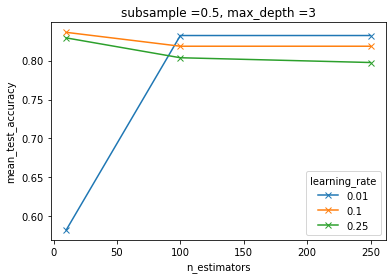

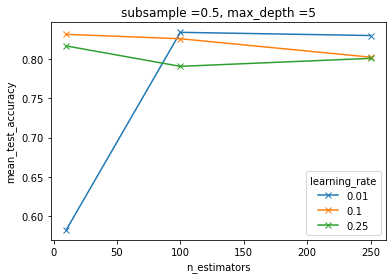

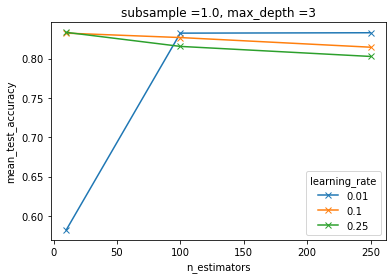

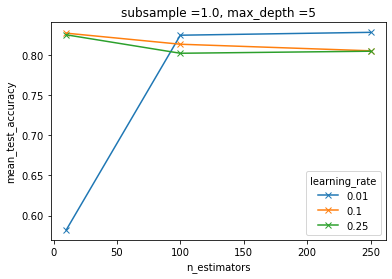

In [194]:
# compile parameter and results into a dataframe
tmp = pd.DataFrame(grid.cv_results_['params'])
tmp2 = pd.DataFrame(grid.cv_results_['mean_test_score'], columns=['mean_test_score'])
tmp = pd.concat([tmp, tmp2], axis=1)
tmp.head()

#send to graphs
for figvals, dfs in tmp.groupby(['subsample', 'max_depth']):
    fig, ax = plt.subplots(figsize=(6,4))
    for label, dfs2 in dfs.groupby('learning_rate'):
        plt.plot(dfs2.n_estimators, dfs2.mean_test_score, marker='x', label=label)
    plt.xlabel('n_estimators')
    plt.ylabel('mean_test_accuracy')
    plt.legend(title='learning_rate')
    figlab = 'subsample =' + str(figvals[0]) + ', max_depth =' + str(figvals[1])
    plt.title(figlab)

When I compare the 3 models:
   * Using Decision Trees: Accuracy using test data was 0.82
   * Random Forests: Mean Accuracy was 0.835
   * Gradient Boosting Model: Mean Acuracy was 0.836
        
The accuracy using Gradient boosting model is slightly higher than the other two. 